## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, RepeatedKFold
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.multioutput import RegressorChain
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
from sklearn import __version__
__version__

'1.0.2'

## Variables de Control

In [3]:
SHOULD_SAMPLE = False
SAMPLE_PER = 0.25
DATASET_NAME = 'Malaga'
TRAIN_MODELS = False
N_FOLDS = 10
RAND_STATE = 42
TEST_SIZE = 0.2
REMOVE_COLUMNS = True
GRIDSEARCH = False
POST_GS = False
N_REPEATS = 3

### Modelos

In [4]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, tol=1e-3, random_state=RAND_STATE), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE)}

## Funciones

In [5]:
def load_pickle(filename: str):
    infile = open(filename, 'rb')
    var = pickle.load(infile, encoding='latin1')
    infile.close()
    return var

def save_to_pickle(filename: str, obj):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def squash(df):
    df_dict = {}
    for x in range(df.shape[0]):
        serie = df.iloc[x,:]
        for index, value in serie.items():
            df_dict.update({f'{serie.name} {index}': f'{value}'})
            
    return pd.DataFrame.from_dict(df_dict, orient='index').T

## Carga de datos

In [6]:
df = pd.read_csv('./data/Malaga.csv', index_col=0)
df.head().T

,0,1,2,3,4
Load C10 pini,0.7728,0.4891,0.5994,1.4102,2.0443
Load C10 voltage,0.9993,0.9996,0.9995,0.9988,0.9982
Load C10 terminal,A10,A10,A10,A10,A10
Load C4 pini,0.9092,0.5754,0.7051,1.6590,2.4051
Load C4 voltage,0.9998,0.9999,0.9998,0.9996,0.9995
Load C4 terminal,A4,A4,A4,A4,A4
Load C5 pini,0.3637,0.2302,0.2821,0.6636,0.9620
Load C5 voltage,0.9990,0.9994,0.9993,0.9982,0.9974
Load C5 terminal,A5,A5,A5,A5,A5
Load C8 pini,1.8184,1.1508,1.4103,3.3181,4.8101


## Preprocesado

In [7]:
df.shape

(42499, 79)

In [8]:
df = df.drop_duplicates()
df.shape

(42499, 79)

## Análisis

### Descripción estadística

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Load C10 pini,33999.0000,4.0209,2.7456,0.1537,1.8145,3.7795,5.3295,21.9205
Load C10 voltage,33999.0000,0.9998,0.0081,0.0231,0.9963,0.9987,1.0009,1.0240
Load C4 pini,42499.0000,4.7306,3.2308,0.1808,2.1347,4.4465,6.2700,25.7888
Load C4 voltage,42499.0000,0.9991,0.0007,0.9793,0.9988,0.9992,0.9996,1.0009
Load C5 pini,42499.0000,1.8923,1.2923,0.0723,0.8539,1.7786,2.5080,10.3155
Load C5 voltage,42499.0000,0.9961,0.0038,0.8249,0.9944,0.9966,0.9988,1.0087
Load C8 pini,42499.0000,9.4613,6.4615,0.3616,4.2694,8.8929,12.5401,51.5776
Load C8 voltage,42499.0000,0.9914,0.0098,0.3586,0.9869,0.9926,0.9977,1.0266
Load C9 pini,33999.0000,3.5479,2.4227,0.1356,1.6010,3.3349,4.7025,19.3416
Load C9 voltage,33999.0000,0.9921,0.0146,0.0548,0.9846,0.9936,0.9984,1.0484


In [10]:
df.describe().T.drop(columns=['count']).to_latex('{}_stats.tex'.format(DATASET_NAME))

### Matriz de valores faltantes

<AxesSubplot:>

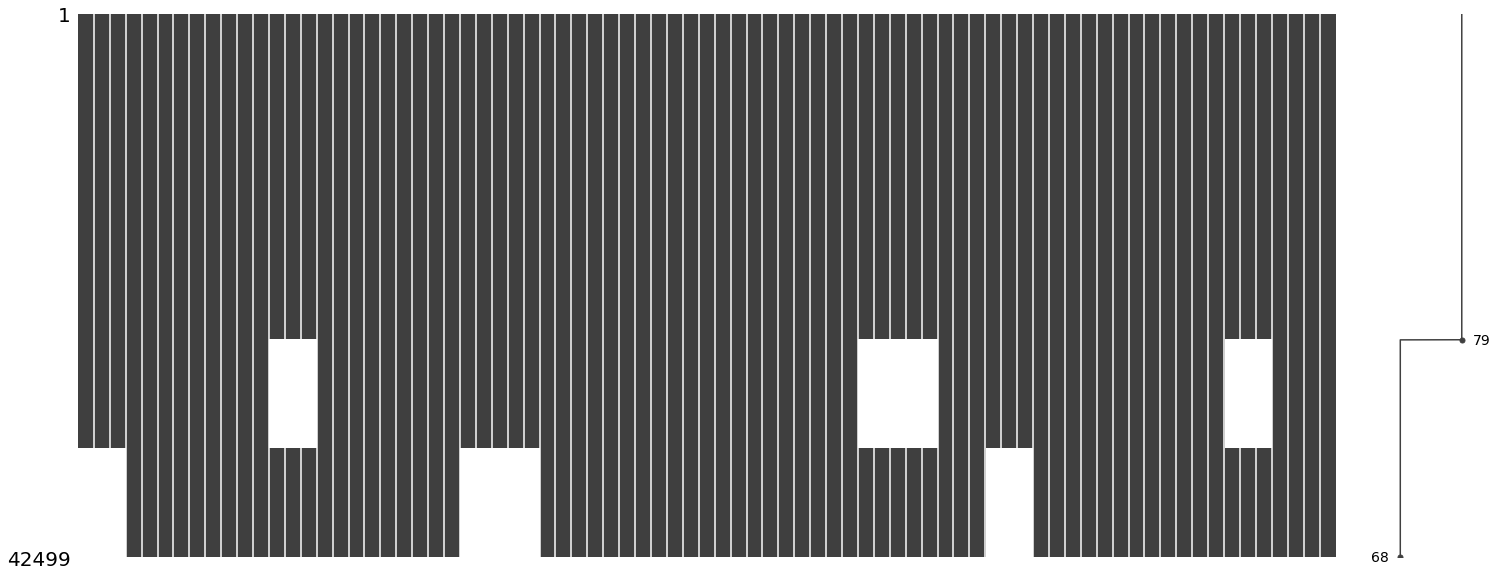

In [11]:
msno.matrix(df)

### Dendrograma de valores faltantes

<AxesSubplot:>

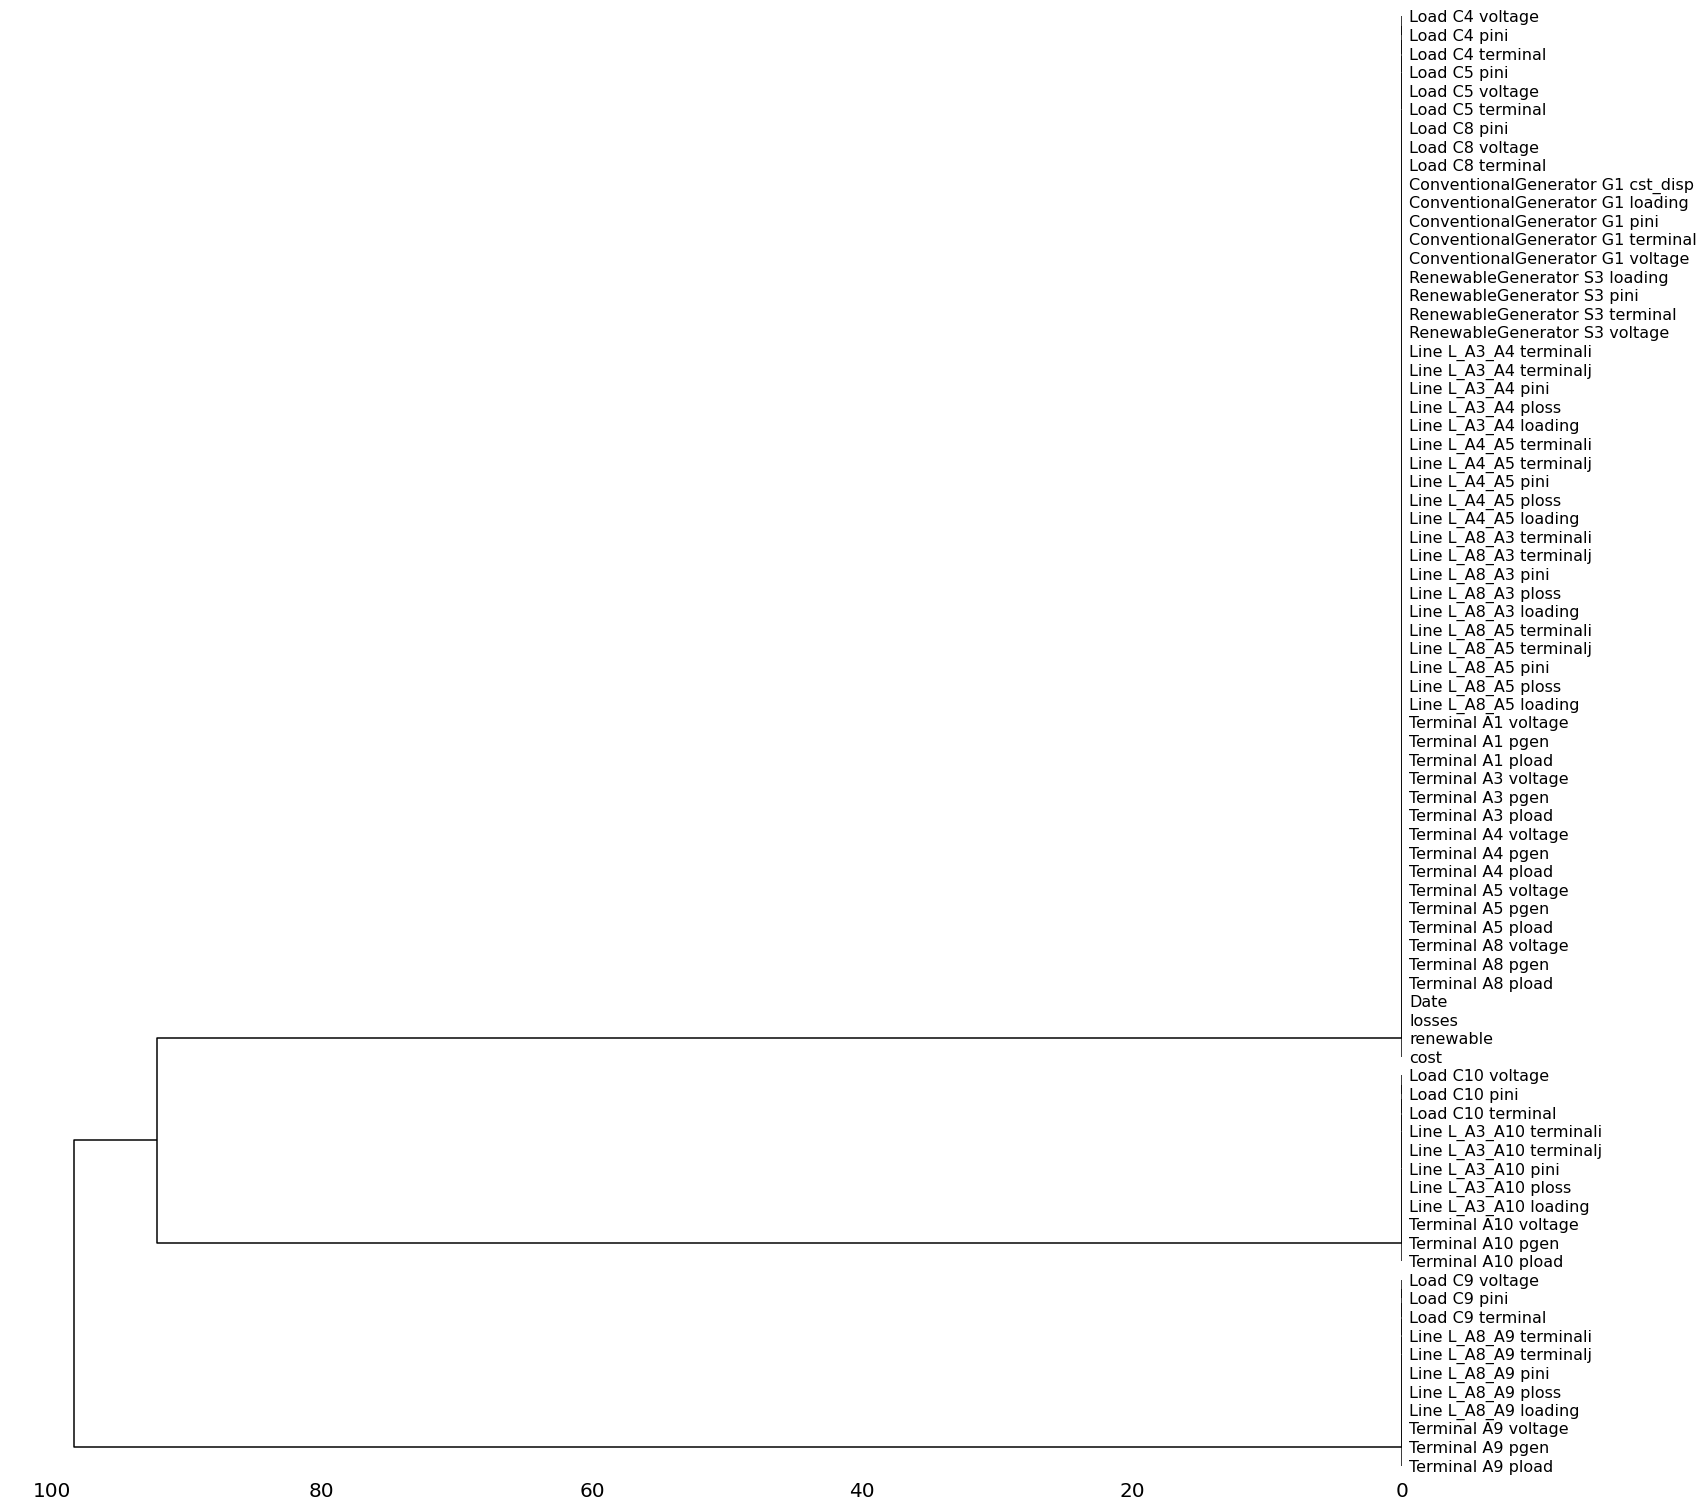

In [12]:
msno.dendrogram(df)

### Correlación entre valores faltantes

<AxesSubplot:>

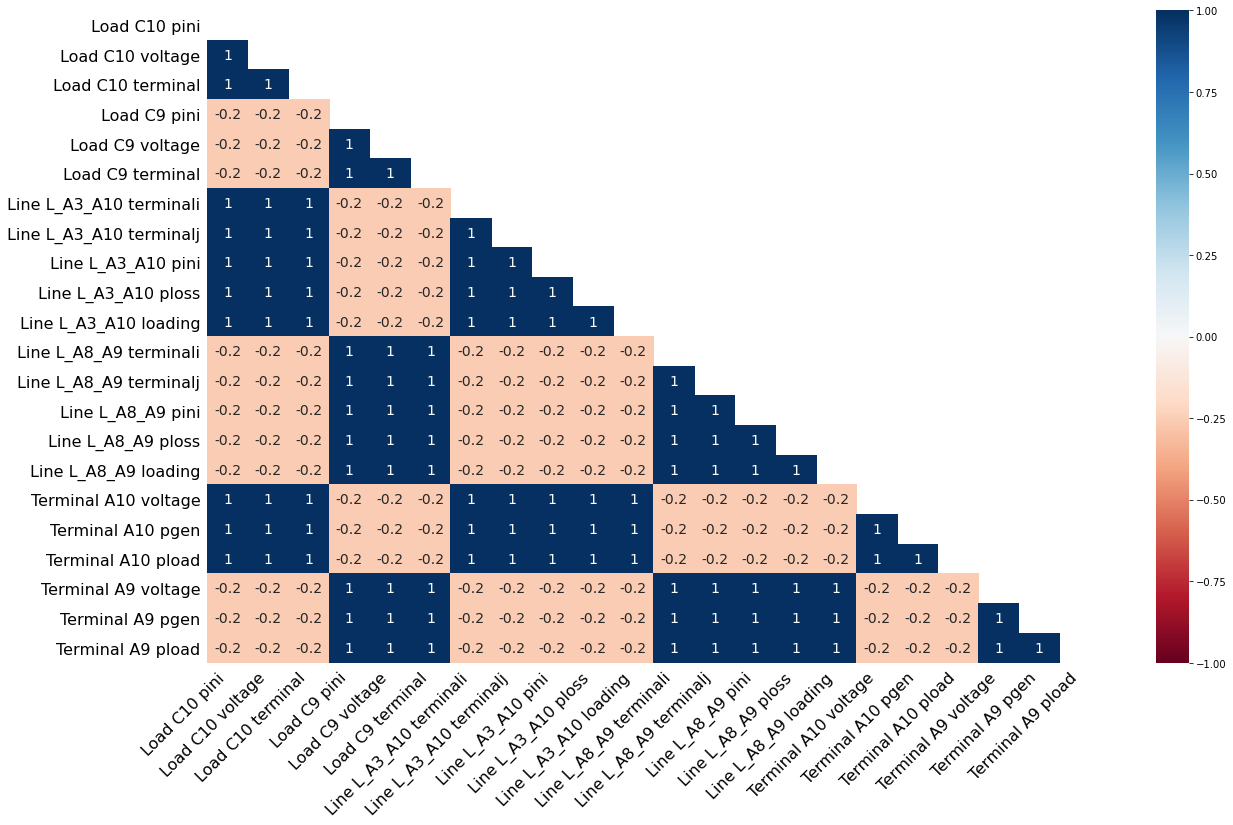

In [13]:
msno.heatmap(df)

### Procesado de valores faltantes

Valores faltantes reemplazados por valor neutro de los campos (0)

In [14]:
df = df.replace(np.NaN, 0)

Se compreuba que el dataset está completo (No hay valores faltantes)

<AxesSubplot:>

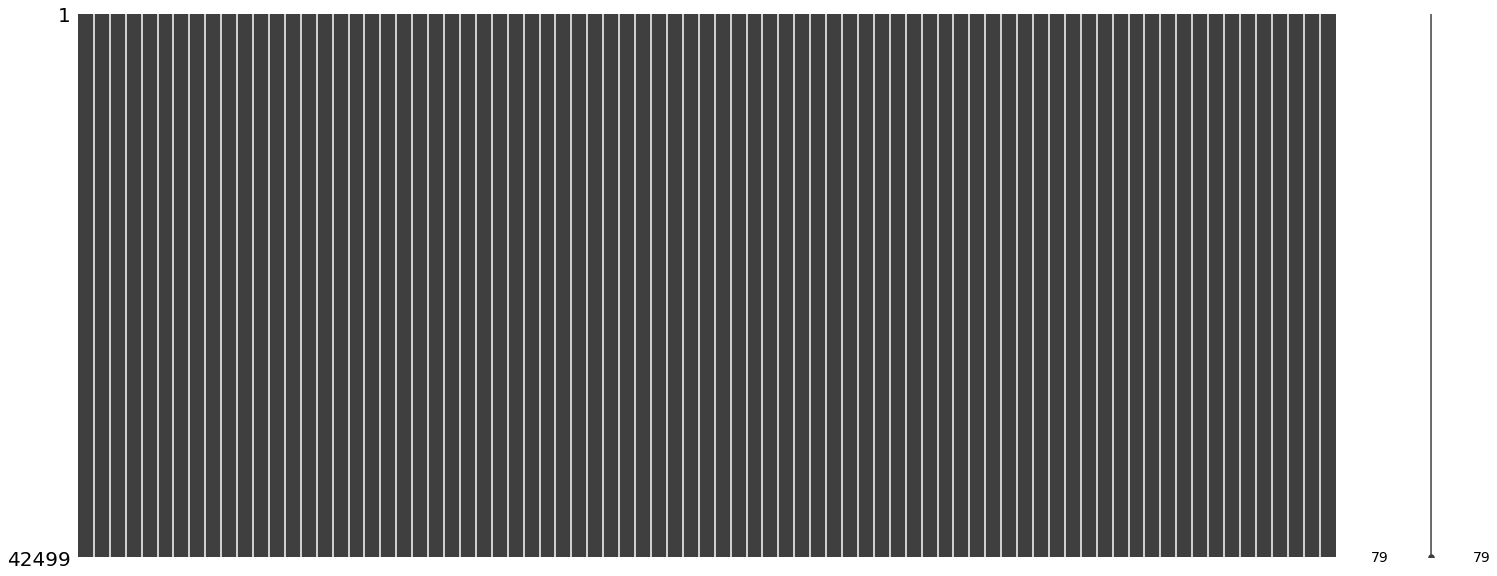

In [15]:
msno.matrix(df)

### Eliminación de columnas con baja varianza

In [16]:
df.shape

(42499, 79)

In [17]:
selector = VarianceThreshold()
columns = df.columns.drop(['Date', 'renewable', 'cost', 'losses']).drop([x for x in df.columns if 'terminal' in x])
selector.fit(df.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in df.columns if 'terminal' in x]))

VarianceThreshold()

In [18]:
selected_columns = list()
removed_columns = list()
for column, selected in zip(columns, selector.get_support()):
    if selected:
        selected_columns.append(column)
    else:
        removed_columns.append(column)

print('Columnas removidas por baja varianza:\n', removed_columns)

Columnas removidas por baja varianza:
 ['ConventionalGenerator G1 voltage', 'Terminal A1 voltage', 'Terminal A1 pload', 'Terminal A3 pload', 'Terminal A4 pgen', 'Terminal A5 pgen', 'Terminal A8 pgen']


In [19]:
if REMOVE_COLUMNS:
    df = df.drop(columns=removed_columns)
    df.shape

### Correlación entre valores del datase

In [20]:
corr_df = df.drop(columns=['losses', 'renewable', 'cost']).corr().round(decimals=2).dropna(how='all', axis=1).dropna(how='all', axis=0)

In [21]:
corr_df.shape

(49, 49)

<AxesSubplot:>

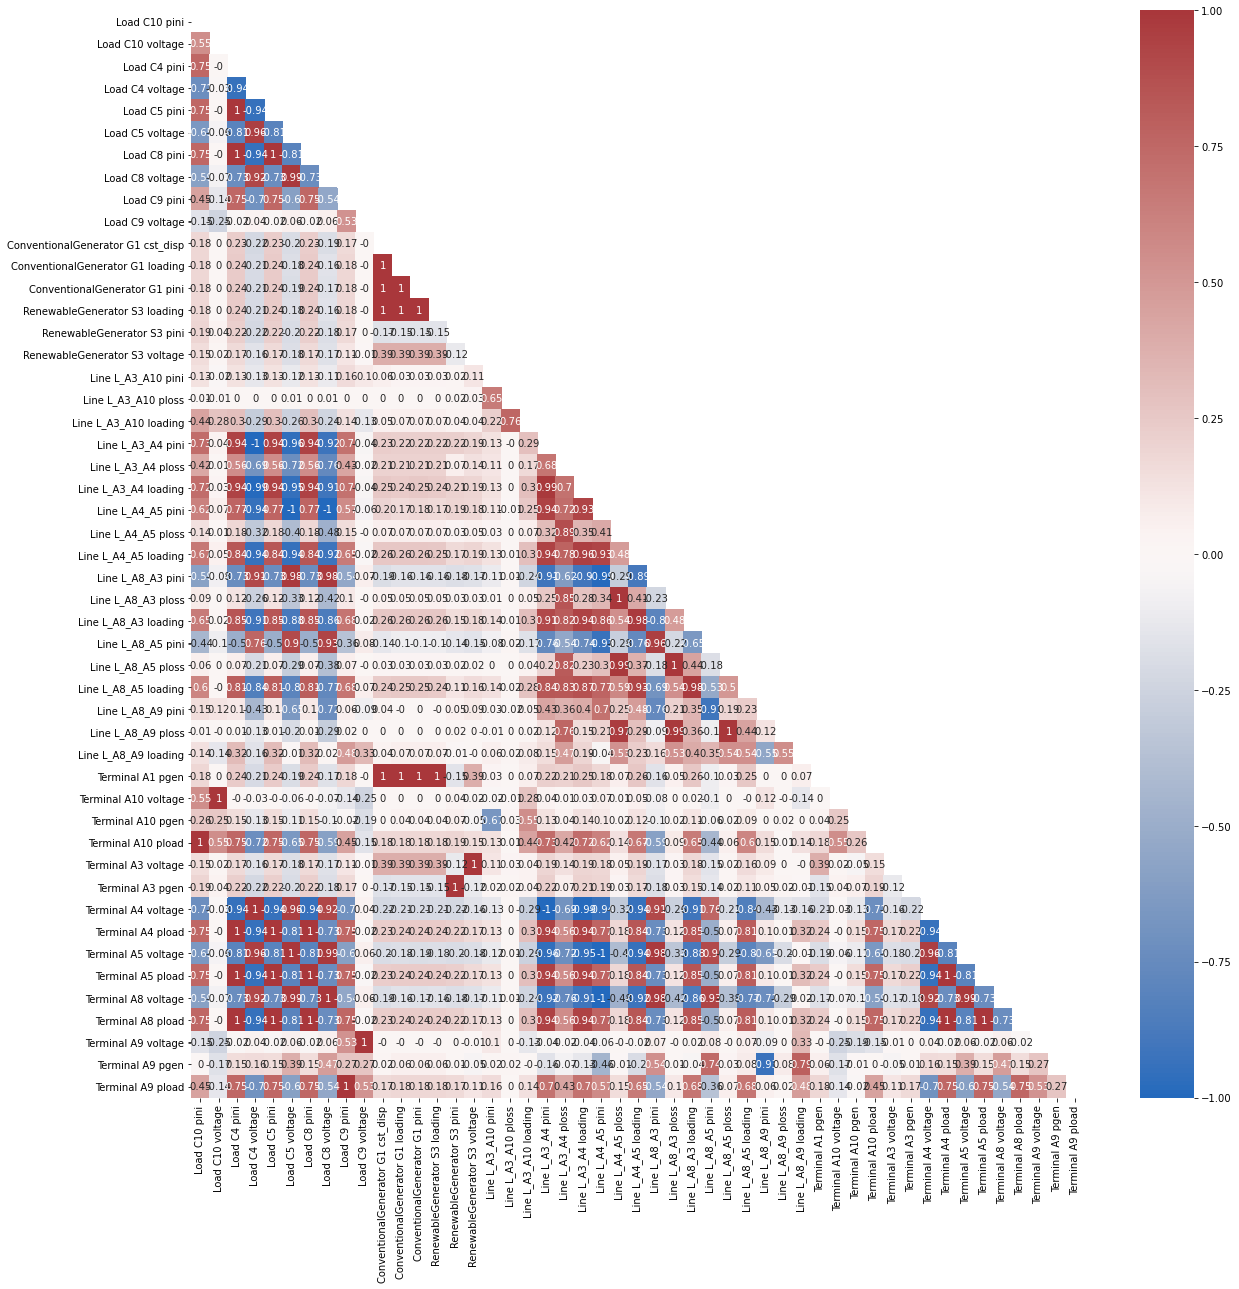

In [22]:
fig, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df, ax=ax, annot=True, mask=mask, cmap=sns.color_palette("vlag", as_cmap=True))

In [23]:
#figure, axis = plt.subplots(5, 6, figsize=(20,20))
#columns = df.columns.drop(['Date', 'renewable', 'cost', 'losses']).drop([x for x in df.columns if 'terminal' in x])

#for i in range(0,5):
#    for j in range(0,6):
#        sns.histplot(df, x=columns[i * 5 + j], bins=20, ax=axis[i, j])

#plt.show()


## Modelado

In [24]:
if SHOULD_SAMPLE:
    dataset = df.sample(frac=SAMPLE_PER, random_state = RAND_STATE)
else:
    dataset = df

# Shuffle dataset
dataset = dataset.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
y = dataset[['losses', 'renewable', 'cost']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X, X_test, y, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

# Hacer kfold, shuffle dataset
cv = KFold(n_splits=N_FOLDS, random_state=RAND_STATE, shuffle=True)

model_scores = {}

if TRAIN_MODELS:
    for key, estimator in estimators.items():
        model_scores[key] = cross_validate(estimator, X, y, cv=cv, scoring=('explained_variance', 'neg_mean_squared_error', 'r2'), n_jobs=-1, return_estimator=True)
    save_to_pickle('{}_Pred_Score.pickle'.format(DATASET_NAME), model_scores)

else:
    model_scores = load_pickle('{}_Pred_Score.pickle'.format(DATASET_NAME))

In [25]:
model_scores_df =  pd.DataFrame.from_dict(model_scores).drop('estimator')
model_scores_df = model_scores_df.apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1)
model_scores_df

,SGD,Linear,SVR,RandomForest,GradientBoosting,MLP
fit_time,0.3412,0.3705,23.8266,180.2380,160.8511,13.5252
score_time,0.0113,0.0129,2.5420,0.1771,0.0260,0.0113
test_explained_variance,0.7692,0.8146,0.5415,0.8731,0.6974,0.5319
test_neg_mean_squared_error,-0.2267,-0.2115,-0.2008,-0.1813,-0.5999,-0.1737
test_r2,0.7690,0.8145,-17.1066,0.8730,0.6897,0.5103


In [26]:
filter = {}
cv_scores = {}
test_keys = []
model_keys = list(model_scores.keys())

for key, item in model_scores.items():
    item_keys = [x for x in item.keys() if 'test' in x]
    test_keys = item_keys
    filter[key] = {}
    for ikey in item_keys:
        filter[key][ikey] = item[ikey]

for test in test_keys:
    cv_scores[test] = {}
    for model in model_keys:
        cv_scores[test][model] = filter[model][test]

In [27]:
test_scores = {}

for key, item in model_scores.items():
    test_scores[key] = list()
    for estimator in model_scores[key]['estimator']:
        test_scores[key].append(estimator.score(X_test, y_test))



### Resultados

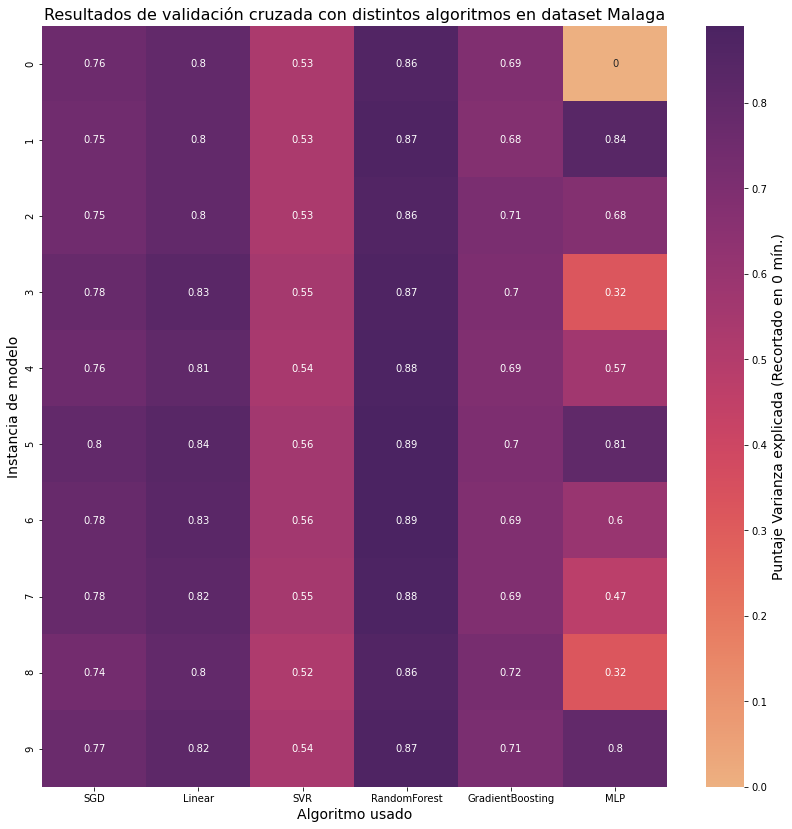

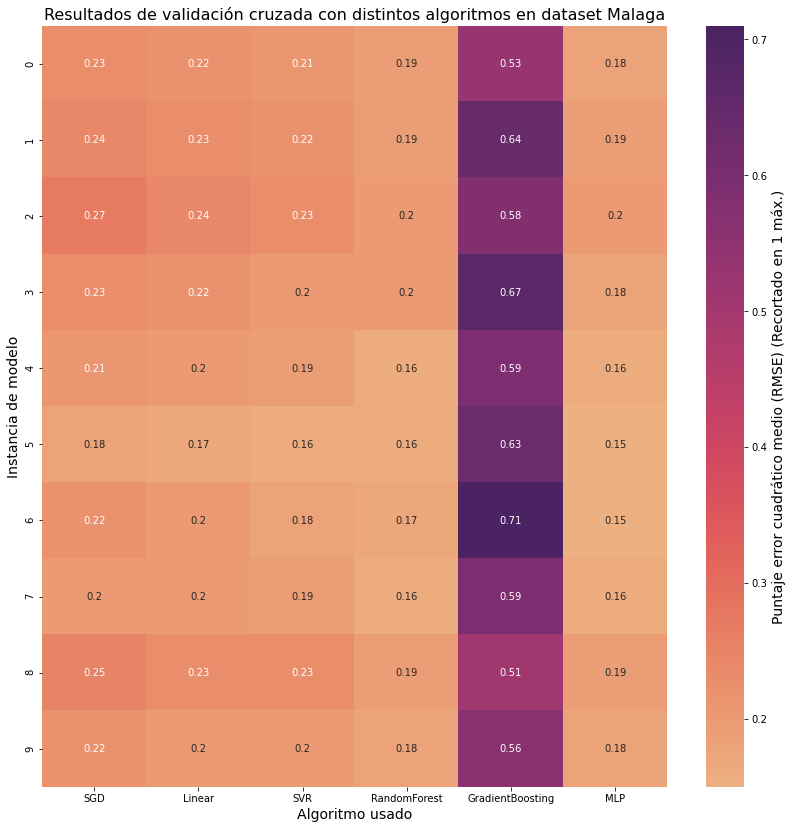

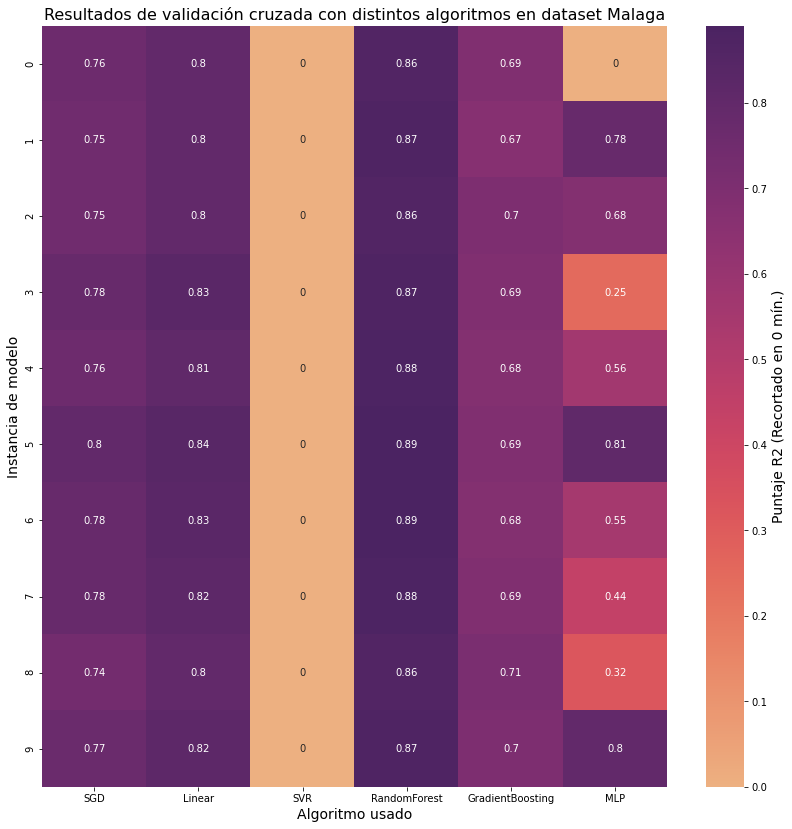

In [28]:
test_label_dict = {'test_explained_variance': 'Puntaje Varianza explicada (Recortado en 0 mín.)',
                   'test_neg_mean_squared_error': 'Puntaje error cuadrático medio (RMSE) (Recortado en 1 máx.)',
                   'test_r2': 'Puntaje R2 (Recortado en 0 mín.)'}

for test, results in cv_scores.items():
    fig, ax = plt.subplots(figsize=(14, 14))
    fig_df = pd.DataFrame.from_dict(results)

    if 'neg' in test:
        fig_df = fig_df.apply(lambda x: x.apply(lambda y: -y))

    ax = sns.heatmap(fig_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': test_label_dict[test]})
    ax.set_title('Resultados de validación cruzada con distintos algoritmos en dataset {}'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Instancia de modelo', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()

In [29]:
test_scores_df = pd.DataFrame.from_dict(test_scores)
test_scores_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SGD,10.0000,0.1421,0.0270,0.1041,0.1209,0.1448,0.1627,0.1806
Linear,10.0000,-1548926040.3467,2411379756.9895,-7290302802.5447,-1933798009.9595,-328104176.9095,-163196601.4081,-6965980.4592
SVR,10.0000,0.5299,0.0007,0.5286,0.5296,0.5299,0.5300,0.5314
RandomForest,10.0000,0.5672,0.0020,0.5647,0.5656,0.5666,0.5692,0.5699
GradientBoosting,10.0000,0.3861,0.0178,0.3652,0.3732,0.3824,0.3944,0.4165
MLP,10.0000,-16.5628,4.7798,-22.8741,-20.3280,-17.1689,-12.3089,-9.4256


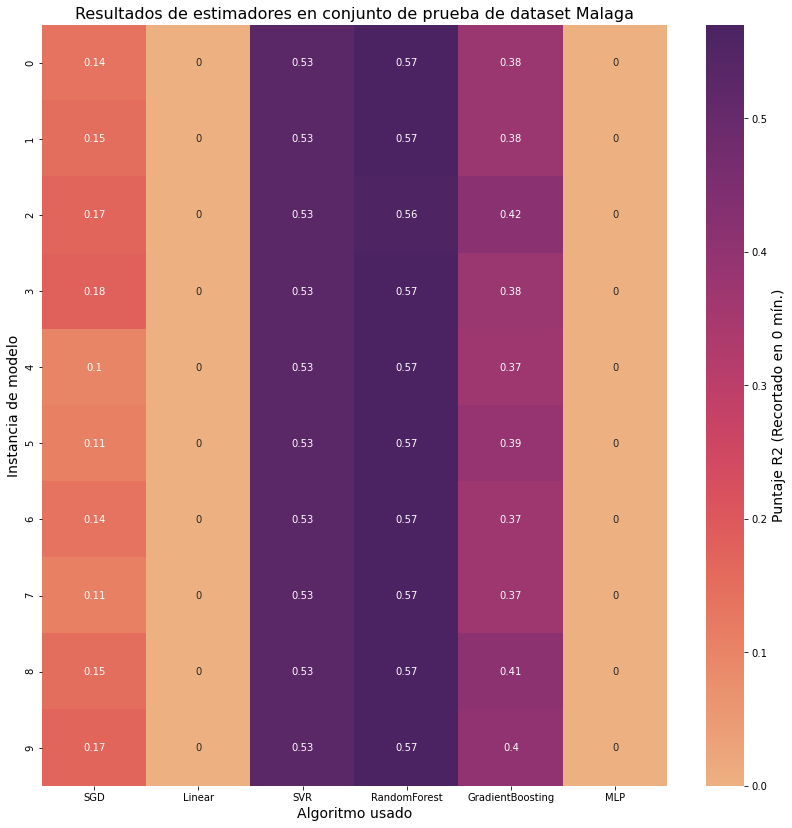

In [30]:
fig, ax = plt.subplots(figsize=(14, 14))

ax = sns.heatmap(test_scores_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': 'Puntaje R2 (Recortado en 0 mín.)'})
ax.set_title('Resultados de estimadores en conjunto de prueba de dataset {}'.format(DATASET_NAME), fontsize = 16)
ax.set_xlabel('Algoritmo usado', fontsize = 14)
ax.set_ylabel('Instancia de modelo', fontsize = 14)
ax.figure.axes[-1].yaxis.label.set_size(14)

plt.show()

### Grid Search

In [31]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, random_state=RAND_STATE), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE)}

In [32]:
# Spaces
hyper_spaces = {
    'SGD': {
        'base_estimator__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'base_estimator__penalty': ['l2', 'l1', 'elasticnet'],
        'base_estimator__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    },
    'Linear': {
        'base_estimator__fit_intercept': [True, False]
    },
    'SVR': {
        'base_estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'base_estimator__gamma': ['scale', 'auto'],
         'base_estimator__C': [0.1, 1, 10, 100]
    },
    'RandomForest': {
        'n_estimators': [10, 50, 100, 200, 400],
        'criterion': ['mse', 'mae'],
        'max_depth': [None, 10, 100, 200],
    },
    'GradientBoosting': {
        'base_estimator__loss': ['ls', 'lad', 'huber', 'quantile'],
        'base_estimator__learning_rate': [0.01, 0.1, 1],
        'base_estimator__n_estimators': [50, 100, 200],
        'base_estimator__criterion': ['friedman_mse', 'mse', 'mae']
    },
    'MLP': {
        'hidden_layer_sizes': [(10,), (20,), (40,), (10, 10,), (20, 10), (40, 10,)],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'activation': ['logistic', 'tanh'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'batch_size': ['auto', 50, 100, 200, 400]
    }
}

if GRIDSEARCH:
    cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_REPEATS, random_state=RAND_STATE)
    X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
    y = dataset[['losses', 'renewable', 'cost']]

    results_dfs = {}

    for name, model in estimators.items():
        start_time = time.time()
        search = GridSearchCV(model, hyper_spaces[name], scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
        result = search.fit(X, y)
        results_dfs[name] = pd.DataFrame.from_dict(result.cv_results_)
        results_dfs[name].to_csv('{}_{}_HyperScores.csv'.format(DATASET_NAME, name))
        print('{}:\nMejor puntaje: {}\nMejor Hiperparámetros: {}\nTiempo: {} s'.format(name, result.best_score_, result.best_params_, (time.time() - start_time)))

else:
    print('GridSearch omitido.')


GridSearch omitido.


In [33]:
if GRIDSEARCH:
    for name, model in estimators.items():
        cols = [x for x in results_dfs[name].columns if 'param_' in x]
        cols.append('mean_test_score')
        print(name)
        display(results_dfs[name][cols])
else:
    print('GridSearch omitido.')

GridSearch omitido.


## Entrenamiento de modelos con hiperparámetros óptimos

In [34]:
estimators = {'SGD': RegressorChain(base_estimator=SGDRegressor(max_iter=1000, random_state=RAND_STATE, learning_rate='adaptive', loss='huber', penalty='l1'), random_state=RAND_STATE),
              'Linear': RegressorChain(base_estimator=LinearRegression(fit_intercept=False), random_state=RAND_STATE),
              'SVR': RegressorChain(base_estimator=SVR(C=1, epsilon=0.1, kernel='rbf'), random_state=RAND_STATE),
              'RandomForest': RandomForestRegressor(random_state=RAND_STATE, criterion='squared_error', max_depth=200, n_estimators=400),
              'GradientBoosting': RegressorChain(base_estimator=GradientBoostingRegressor(random_state=RAND_STATE, criterion='squared_error', learning_rate=0.1, loss='huber', n_estimators=200), random_state=RAND_STATE),
              'MLP': MLPRegressor(random_state=RAND_STATE, activation='logistic', hidden_layer_sizes=(40,10), learning_rate='constant', solver='adam')}

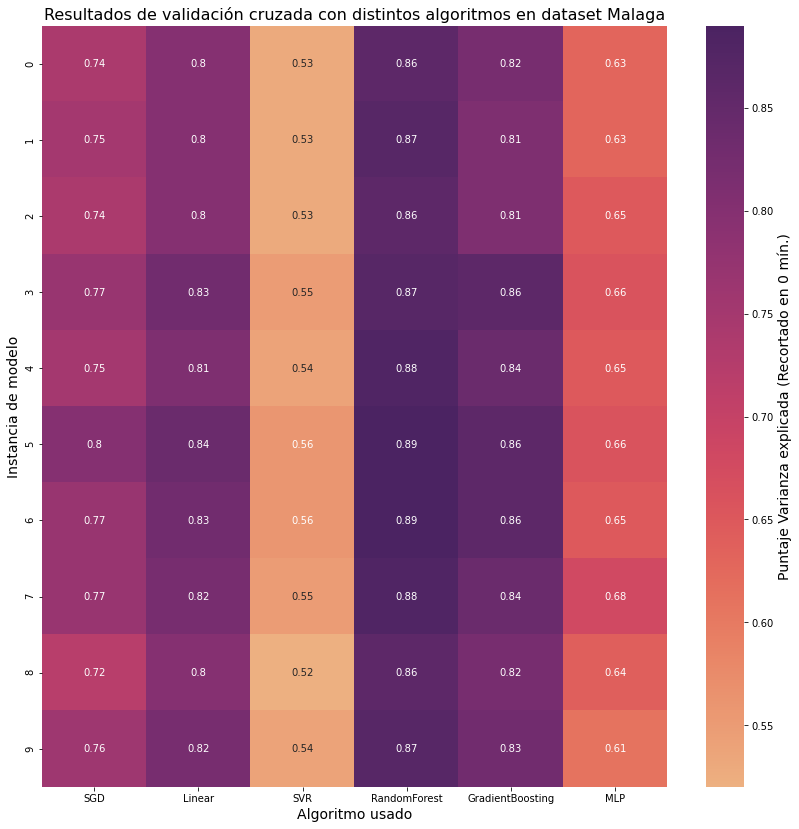

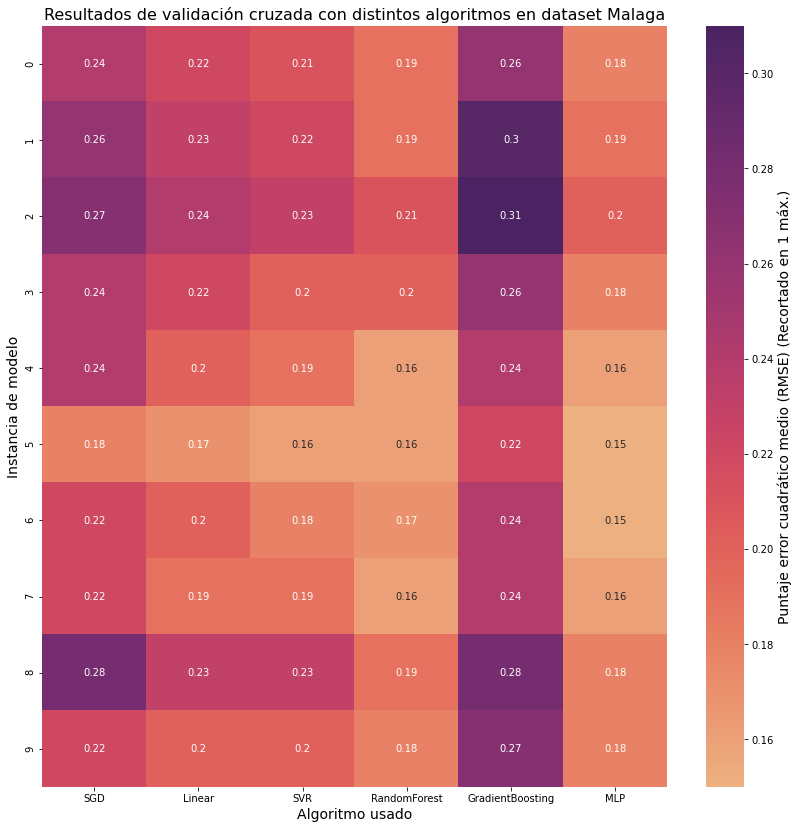

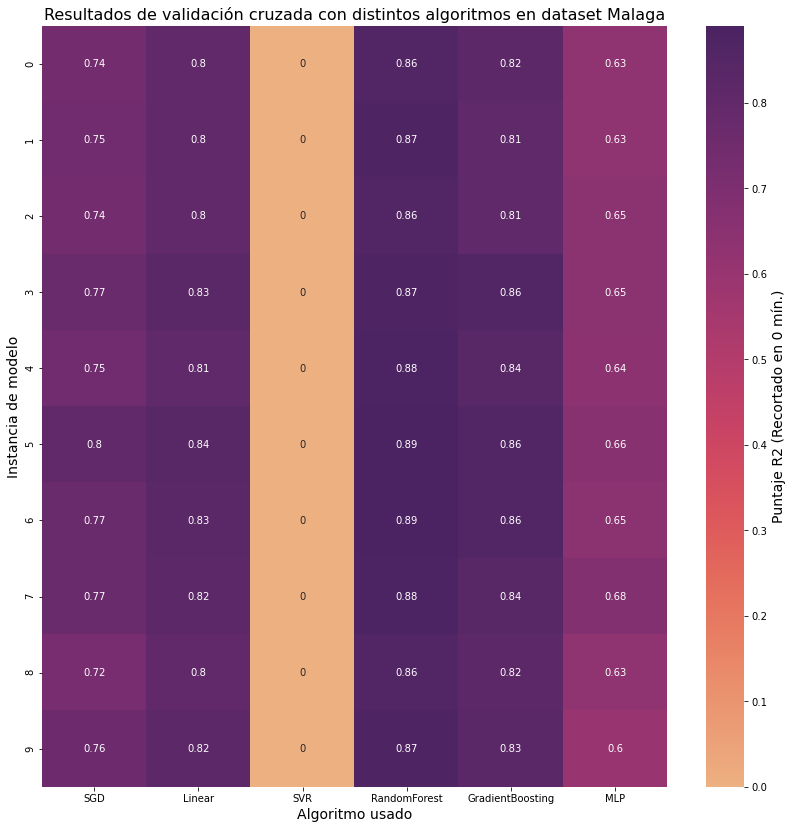

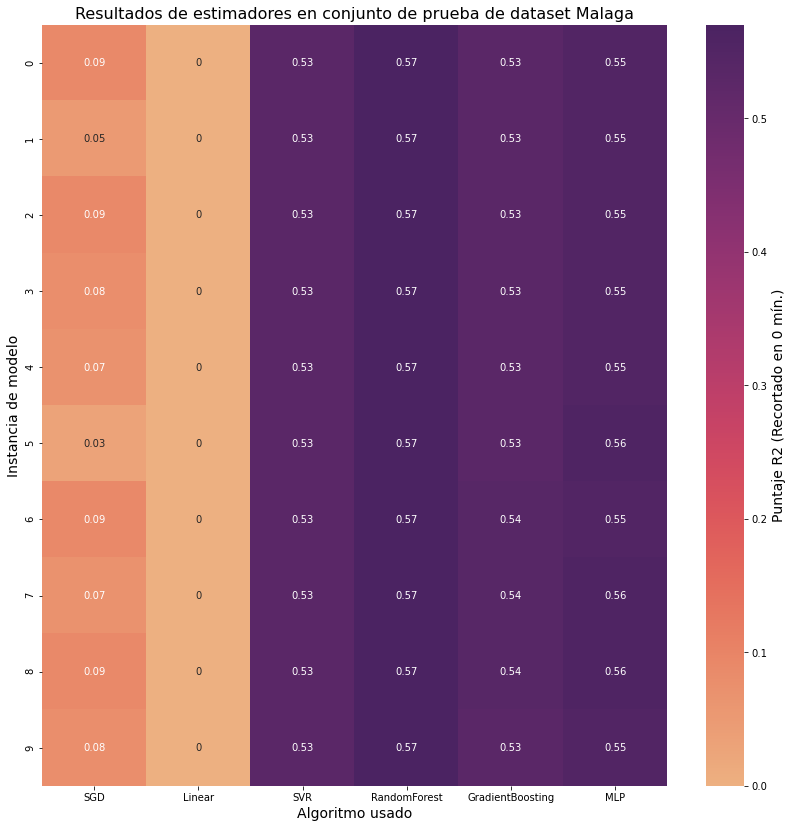

In [35]:
if SHOULD_SAMPLE:
    dataset = df.sample(frac=SAMPLE_PER, random_state = RAND_STATE)
else:
    dataset = df

# Shuffle dataset
dataset = dataset.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

X = dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x])
y = dataset[['losses', 'renewable', 'cost']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X, X_test, y, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

# Hacer kfold, shuffle dataset
cv = KFold(n_splits=N_FOLDS, random_state=RAND_STATE, shuffle=True)

model_scores = {}

if POST_GS:
    for key, estimator in estimators.items():
        model_scores[key] = cross_validate(estimator, X, y, cv=cv, scoring=('explained_variance', 'neg_mean_squared_error', 'r2'), n_jobs=-1, return_estimator=True)
    
    save_to_pickle('{}_Opt_Score.pickle'.format(DATASET_NAME), model_scores)

else:
    model_scores = load_pickle('{}_Opt_Score.pickle'.format(DATASET_NAME)) 

model_scores_df =  pd.DataFrame.from_dict(model_scores).drop('estimator')
model_scores_df = model_scores_df.apply(lambda x: x.apply(lambda y: np.mean(y)), axis=1)

filter = {}
cv_scores = {}
test_keys = []
model_keys = list(model_scores.keys())

for key, item in model_scores.items():
    item_keys = [x for x in item.keys() if 'test' in x]
    test_keys = item_keys
    filter[key] = {}
    for ikey in item_keys:
        filter[key][ikey] = item[ikey]

for test in test_keys:
    cv_scores[test] = {}
    for model in model_keys:
        cv_scores[test][model] = filter[model][test]

test_scores = {}

for key, item in model_scores.items():
    test_scores[key] = list()
    for estimator in model_scores[key]['estimator']:
        test_scores[key].append(estimator.score(X_test, y_test))

test_label_dict = {'test_explained_variance': 'Puntaje Varianza explicada (Recortado en 0 mín.)',
                'test_neg_mean_squared_error': 'Puntaje error cuadrático medio (RMSE) (Recortado en 1 máx.)',
                'test_r2': 'Puntaje R2 (Recortado en 0 mín.)'}

for test, results in cv_scores.items():
    fig, ax = plt.subplots(figsize=(14, 14))
    fig_df = pd.DataFrame.from_dict(results)

    if 'neg' in test:
        fig_df = fig_df.apply(lambda x: x.apply(lambda y: -y))

    ax = sns.heatmap(fig_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': test_label_dict[test]})
    ax.set_title('Resultados de validación cruzada con distintos algoritmos en dataset {}'.format(DATASET_NAME), fontsize = 16)
    ax.set_xlabel('Algoritmo usado', fontsize = 14)
    ax.set_ylabel('Instancia de modelo', fontsize = 14)
    ax.figure.axes[-1].yaxis.label.set_size(14)

    plt.show()

test_scores_df = pd.DataFrame.from_dict(test_scores)

fig, ax = plt.subplots(figsize=(14, 14))

ax = sns.heatmap(test_scores_df.clip(lower=0, upper=1).round(decimals=2), annot = True, cmap=sns.color_palette('flare', as_cmap=True), cbar_kws={'label': 'Puntaje R2 (Recortado en 0 mín.)'})
ax.set_title('Resultados de estimadores en conjunto de prueba de dataset {}'.format(DATASET_NAME), fontsize = 16)
ax.set_xlabel('Algoritmo usado', fontsize = 14)
ax.set_ylabel('Instancia de modelo', fontsize = 14)
ax.figure.axes[-1].yaxis.label.set_size(14)

plt.show()


In [36]:
model_scores['RandomForest']['estimator'][3]

RandomForestRegressor(max_depth=200, n_estimators=400, random_state=42)

In [37]:
#import matplotlib.pyplot as plt
#from sklearn import tree

#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=800)
#tree.plot_tree(model_scores['RandomForest']['estimator'][3].estimators_[0], filled = True);

#fig.show()

## Interpretabilidad

In [38]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

### Linear

In [39]:
# modelo linear, importancia de atributos

linear_estimator = model_scores['Linear']['estimator'][0]
linear_estimator.estimators_[0].coef_

array([-5.23197960e+08, -8.49992319e+08,  5.90842858e+07, -1.94122721e+07,
        2.37195907e+08,  6.90020116e+08, -1.22903176e+08, -2.24160226e+09,
       -4.36899548e+07,  1.07301674e+08, -2.13910639e-03,  5.63576818e-02,
        7.08646443e+07,  5.09360090e-01, -9.28458027e+07,  3.00334496e+08,
        1.47824287e-02,  1.42407250e-01, -4.25577164e-05,  2.43823647e+00,
       -4.57472786e-01,  1.21167302e-03,  3.97476346e+01, -8.71216755e-01,
       -9.24634933e-03,  3.26670415e+01,  9.62714296e-01,  9.99675691e-03,
        1.98589693e+01, -1.10479672e+01, -4.01741266e-03,  6.06081957e+00,
        2.29378547e+00,  1.21572614e-03, -7.08646448e+07,  8.49992319e+08,
        8.37290287e-03,  5.23197960e+08, -3.00334496e+08,  9.28458026e+07,
        1.94122870e+07, -8.53304067e+07, -6.90020112e+08, -2.37196030e+08,
        2.24160223e+09,  1.49149420e+08, -1.07301674e+08, -9.50759649e-03,
        4.36899548e+07])

In [40]:
pad_coefs = list()
for estimator in linear_estimator.estimators_:
    pad_coefs.append(np.pad(estimator.coef_, (0, col_length - len(estimator.coef_)), mode='constant', constant_values=0))


Se considera el orden de magnitud de cada coeficiente para comparar la relevancia de cada atributo. Se considera que el atributo no tiene relevancia para la predicción si el orden de magnitud es menor que cero.

In [41]:
linear_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
linear_coefs_df = linear_coefs_df.apply(lambda x: np.log10(np.maximum(np.abs(x), 1)))
linear_coefs_df

,losses,renewable,cost
Load C10 pini,8.7187,11.4481,10.4291
Load C10 voltage,8.9294,10.5890,11.4809
Load C4 pini,7.7715,9.5899,10.4724
Load C4 voltage,7.2881,9.8498,10.7232
Load C5 pini,8.3751,10.1307,11.0106
Load C5 voltage,8.8389,11.4159,11.7308
Load C8 pini,8.0896,9.8485,10.7130
Load C8 voltage,9.3506,9.8477,11.2742
Load C9 pini,7.6404,9.5274,10.4096
Load C9 voltage,8.0306,9.8016,10.6899


### Random Forest

In [42]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)

In [43]:
rforest_estimator = model_scores['RandomForest']['estimator'][0]
rforest_estimator.feature_importances_

array([0.00693535, 0.00506966, 0.00193001, 0.00457828, 0.00190823,
       0.00289362, 0.0019192 , 0.00250243, 0.00425178, 0.00420217,
       0.43924546, 0.00760062, 0.15809076, 0.01980478, 0.01507911,
       0.00983869, 0.0048588 , 0.00442024, 0.0042887 , 0.00199809,
       0.00290885, 0.00281704, 0.00205254, 0.00244644, 0.00257723,
       0.00250351, 0.00230491, 0.00212522, 0.00380671, 0.00270399,
       0.00275381, 0.00309152, 0.00556559, 0.00863379, 0.16128095,
       0.00549511, 0.01506822, 0.00683535, 0.00962393, 0.01526583,
       0.00441672, 0.00192043, 0.00289879, 0.00197249, 0.00247115,
       0.00200162, 0.00496458, 0.01446069, 0.00361701])

Se considera importancia de cada atributo. Mientras mayor el valor, más importante es. Este valor corresponde a Gini Importance / Mean Decrease in Impurity (MDI)

In [44]:
#linear_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
forest_importance_df = pd.DataFrame([rforest_estimator.feature_importances_], columns=X_cols).T
forest_importance_df

,0
Load C10 pini,0.0069
Load C10 voltage,0.0051
Load C4 pini,0.0019
Load C4 voltage,0.0046
Load C5 pini,0.0019
Load C5 voltage,0.0029
Load C8 pini,0.0019
Load C8 voltage,0.0025
Load C9 pini,0.0043
Load C9 voltage,0.0042


Debido a la diferencia de ordenes de magnitud en la importancia que se le otroga a cada atributo, se hace esta comparación también. Valores mayores son mejores.

In [45]:
forest_importance_magnitude_df = forest_importance_df.apply(lambda x: np.log10(np.abs(x)))
forest_importance_magnitude_df

,0
Load C10 pini,-2.1589
Load C10 voltage,-2.2950
Load C4 pini,-2.7144
Load C4 voltage,-2.3393
Load C5 pini,-2.7194
Load C5 voltage,-2.5386
Load C8 pini,-2.7169
Load C8 voltage,-2.6016
Load C9 pini,-2.3714
Load C9 voltage,-2.3765


### Gradient Boosting

In [46]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

In [47]:
gboost_estimator = model_scores['GradientBoosting']['estimator'][1]
gboost_estimator.estimators_[2].feature_importances_

array([5.70145725e-06, 1.37678480e-05, 2.57908227e-06, 1.68629650e-07,
       3.53020537e-06, 4.60985065e-07, 8.40205079e-06, 1.75654550e-05,
       3.23255015e-05, 1.63240894e-05, 4.25739261e-01, 1.13301038e-02,
       1.84759127e-01, 1.32578638e-02, 2.81101392e-03, 3.12849452e-05,
       1.34324334e-05, 6.13777590e-06, 7.39092900e-07, 3.01305622e-05,
       1.61635525e-05, 1.75681168e-05, 3.44935134e-07, 0.00000000e+00,
       2.18664460e-07, 0.00000000e+00, 7.25492310e-07, 5.36719584e-07,
       8.55818612e-06, 1.81551074e-06, 8.42859167e-07, 2.32241155e-06,
       2.69844951e-06, 3.20725208e-06, 2.75681900e-01, 8.79732228e-06,
       7.15280031e-07, 5.63247201e-06, 1.32177955e-05, 8.89915677e-03,
       9.00025651e-06, 3.28325295e-06, 1.30756088e-06, 2.84995020e-06,
       0.00000000e+00, 1.03565619e-05, 1.71237460e-05, 1.07048002e-05,
       1.52495291e-05, 4.69300789e-03, 7.24927751e-02])

In [48]:
pad_coefs = list()
for estimator in gboost_estimator.estimators_:
    pad_coefs.append(np.pad(estimator.feature_importances_, (0, col_length - len(estimator.feature_importances_)), mode='constant', constant_values=0))

In [49]:
gboost_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
gboost_coefs_df

,losses,renewable,cost
Load C10 pini,0.0020,0.0000,0.0000
Load C10 voltage,0.0128,0.0000,0.0000
Load C4 pini,0.0382,0.0000,0.0000
Load C4 voltage,0.0003,0.0000,0.0000
Load C5 pini,0.0056,0.0000,0.0000
Load C5 voltage,0.0001,0.0000,0.0000
Load C8 pini,0.0387,0.0001,0.0000
Load C8 voltage,0.0000,0.0000,0.0000
Load C9 pini,0.0010,0.0000,0.0000
Load C9 voltage,0.0034,0.0000,0.0000


### Stochastic Gradient Descent

In [50]:
X_cols = list(dataset.drop(columns=['Date', 'renewable', 'cost', 'losses']).drop(columns=[x for x in dataset.columns if 'terminal' in x]).columns)
X_cols.append('losses')
X_cols.append('renewable')
col_length = len(X_cols)

In [51]:
sgd_estimator = model_scores['SGD']['estimator'][0]
sgd_estimator.estimators_[0].coef_

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -7.89034291e-05,  0.00000000e+00,
        5.73518685e-04,  0.00000000e+00,  2.37666861e-03,  0.00000000e+00,
        7.34727440e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.06236585e-04,  0.00000000e+00,  0.00000000e+00,
        3.50834104e-04,  0.00000000e+00,  1.27641519e-03,  0.00000000e+00,
        0.00000000e+00,  9.88125610e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.89034291e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [52]:
pad_coefs = list()
for estimator in sgd_estimator.estimators_:
    pad_coefs.append(np.pad(estimator.coef_, (0, col_length - len(estimator.coef_)), mode='constant', constant_values=0))

In [53]:
sgd_coefs_df = pd.DataFrame(pad_coefs, columns=X_cols).T.set_axis(['losses', 'renewable', 'cost'], axis=1, inplace=False)
sgd_coefs_df

,losses,renewable,cost
Load C10 pini,0.0000,0.0349,0.0000
Load C10 voltage,0.0000,-0.0040,-0.0004
Load C4 pini,0.0000,0.0301,0.0000
Load C4 voltage,0.0000,-0.0048,0.0000
Load C5 pini,0.0000,0.0301,0.0000
Load C5 voltage,0.0000,0.0000,0.0000
Load C8 pini,0.0000,0.0301,0.0000
Load C8 voltage,0.0000,0.0000,0.0000
Load C9 pini,0.0000,0.0303,-0.0001
Load C9 voltage,0.0000,-0.0011,0.0000
